In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
from os import path
import pandas as pd
from zipfile import ZipFile
from StringIO import StringIO
import urllib2
import requests
import geopandas as gp
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import pylab as pl

# Make plots prettyful
pl.style.use('fivethirtyeight')

In [3]:
# A function to pull citibike data from the web directly into memory for a given list of months.
# Months can be any of the following: ['01', '02', '03', '04', '05', '06']
def pullCitibikeData(months):
    ride_frames = []

    for month in months:
        url = "https://s3.amazonaws.com/tripdata/2015%s-citibike-tripdata.zip" % month
        r = urllib2.urlopen(url).read()
        f = ZipFile(StringIO(r))
        csv = f.open("2015%s-citibike-tripdata.csv" % month)
        frame = pd.read_csv(csv)
        ride_frames.append(frame)

    # Concatenate all the individual months into one.
    return pd.concat(ride_frames, ignore_index=True)

HOME_DIR = 'C:\Users\Jeremy\Documents\workspace\pui_midterm'

#Define a function to handle path for windows users without PUI2015 environment variable
def getFilePath(relativePath, directory=HOME_DIR):
    if os.getenv('PUI2015'):
        p = path.join(os.getenv('PUI2015'), relativePath)
        if path.exists(p):
            return p
    
    return path.join(directory, relativePath)

In [4]:
rides = pullCitibikeData(['01', '06'])

In [5]:
r = requests.get('http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/stationzips.json')
station_zip = r.json()

In [6]:
# Expect Data in PUI2015/Manhattan
pluto = gp.GeoDataFrame.from_file(getFilePath("Manhattan/MNMapPLUTO.shp"))

In [7]:
units_per_zip = pluto.groupby('ZipCode')['UnitsRes'].sum()

In [8]:
# The column doesn't matter for count, so just use tripduration
rides_per_station = rides.groupby('start station id')['tripduration'].count()

In [9]:
# Create a dictionary of zip codes to rides, units and number of stations
zips = {}
for station_id, zip_code in station_zip.iteritems():
    # validate the zipcode.  83 and NaN are not valid zip codes.
    if zip_code >= 10000:
        
        # Not all the stations in the json are in the ride data
        # Might be newer stations?
        if int(station_id) in rides_per_station:
            
            # If we don't have data for this zipcode in the pluto data skip
            if zip_code not in units_per_zip:
                continue
            
            # Add the zipcode if it's the first time we've seen it 
            if zip_code not in zips:
                zips[zip_code] = {'rides': 0, 'units': units_per_zip[zip_code], 'stations': 0}

            # Add the number of rides from that station
            zips[zip_code]['rides'] += rides_per_station[int(station_id)]
            
            # All keep track of the number of stations in the zip code.
            # Could be useful, eh?
            zips[zip_code]['stations'] += 1

In [10]:
# Create a dataframe to do regression with statsmodels
# Create a list of zip_codes to ensure we get a consistent order since
# "technically" python dicts don't ensure ordering.
zip_codes = zips.keys()
df = pd.DataFrame({
    'zip_code': zip_codes,
    'rides': [zips[z]['rides'] for z in zip_codes],
    'units': [zips[z]['units'] for z in zip_codes],
    'stations': [zips[z]['stations'] for z in zip_codes]
})

In [11]:
def doRegressionAndPlot(df, title):
    '''
    Pass in a dataframe and run the regression and plot the results.
    '''
    # Run Linear Regression
    mod_linear = smf.ols(formula='rides ~ units', data = df).fit()
    print "***********Linear Regression***********"
    print mod_linear.summary()
    
    # Polynomial Regression
    # Create units^2 variable
    df['units2'] = df['units']**2
    mod_poly = smf.ols(formula='rides ~ units2 + units', data = df).fit()
    print "\n\n***********Polynomial Regression***********"
    print mod_poly.summary()
    
    lr_stat, p_value, _ = mod_poly.compare_lr_test(mod_linear)
    print "\n\n*Comparison of the two tests: LR Statistic: %s; P-Value: %s*\n\n" % (lr_stat, p_value)
    
    
    # Plot the data
    figure, ax = pl.subplots(figsize=(10,10))
    pl.scatter(df['units'], df['rides'], s=50, label='Data Points')

    # Plot polynomial regression
    x = np.linspace(df['units'].min()-10000, df['units'].max()+10000, 100)
    y = mod_poly.params[0] + (x**2)*mod_poly.params[1] + x*mod_poly.params[2]
    ax.plot(x, y, 'r--', label='2nd Degree Regression')

    # Plot linear regression
    y = mod_linear.params[0] + x*mod_linear.params[1]
    ax.plot(x, y, 'g--', label='Linear Regression')

    ax.legend(loc='upper left')
    ax.set_title(title)
    ax.set_ylabel('Number of Citibike Rides')
    ax.set_xlabel('Number of Residential Units')

***********Linear Regression***********
                            OLS Regression Results                            
Dep. Variable:                  rides   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     12.17
Date:                Mon, 26 Oct 2015   Prob (F-statistic):            0.00219
Time:                        11:34:56   Log-Likelihood:                -267.22
No. Observations:                  23   AIC:                             538.4
Df Residuals:                      21   BIC:                             540.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   

c:\Users\Jeremy\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


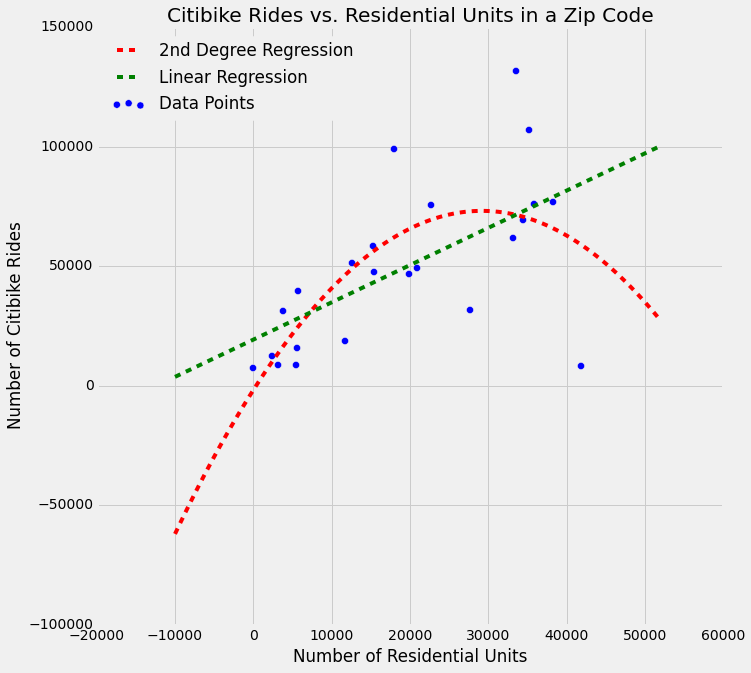

In [12]:
doRegressionAndPlot(df, 'Citibike Rides vs. Residential Units in a Zip Code')

The total number of citibike rides originating in a zip code vs. the number of residential units in that zip code.  Fit with both a linear regression and 2nd degree polynomial regression.  Citibike ride data is taken from January and June of 2015 and residential unit data is from MapPluto.

###Question 3

When using the log likelihood ratio test we get a test statistic of 5.04049409704 and a P-Value: 0.0247614264976, meaning the polynomial test is better and we can reject the linear regression at a .05 significance level.

### Question 4

There is a clear outlier in 10023, west Central Park.  This is near the north of the citibike area yet has a lot of residential units.  We can go back up to our dataframe and see that, indeed, there is only a single station in this zip code during our time frame (jan/jun).

One thing we can do is control for the number of stations.  For example by introducing it as a variable into our regression.

In [13]:
mod_linear = smf.ols(formula='rides ~ units + stations', data = df).fit()
print mod_linear.summary()

                            OLS Regression Results                            
Dep. Variable:                  rides   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     36.69
Date:                Mon, 26 Oct 2015   Prob (F-statistic):           2.03e-07
Time:                        11:34:58   Log-Likelihood:                -254.76
No. Observations:                  23   AIC:                             515.5
Df Residuals:                      20   BIC:                             518.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    486.7800   6892.971      0.071      0.9

We can see here that including stations in the regression dramatically reduces the impact of residential units on the number of rides.  This could be because number of stations is already highly correlated with residential units.  But it could also be that some of these locations as being supply constrained and not demand constrained.

In [14]:
# Take a look at the correlations between the variabless
df.corr()

,rides,stations,units,zip_code,units2
rides,1.000000,0.886127,0.605704,-0.500213,0.500310
stations,0.886127,1.000000,0.662901,-0.571965,0.559283
units,0.605704,0.662901,1.000000,-0.474905,0.969297
zip_code,-0.500213,-0.571965,-0.474905,1.000000,-0.368461
units2,0.500310,0.559283,0.969297,-0.368461,1.000000


We do indeed see a high correlation already between units and stations.  Indicating that stations were built were there was demand.


So to address the issue of zip codes which are currently underdeveloped for question #4, I'll arbitrarily filter the dataframe to only include zip codes with 5 or more stations to eliminate this effect.

In [15]:
df_filtered = df[df.stations>=5]

***********Linear Regression***********
                            OLS Regression Results                            
Dep. Variable:                  rides   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     17.18
Date:                Mon, 26 Oct 2015   Prob (F-statistic):           0.000678
Time:                        11:34:58   Log-Likelihood:                -216.75
No. Observations:                  19   AIC:                             437.5
Df Residuals:                      17   BIC:                             439.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   

c:\Users\Jeremy\Anaconda\lib\site-packages\scipy\stats\stats.py:1233: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  int(n))
c:\Users\Jeremy\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy





***********Polynomial Regression***********
                            OLS Regression Results                            
Dep. Variable:                  rides   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     8.311
Date:                Mon, 26 Oct 2015   Prob (F-statistic):            0.00335
Time:                        11:34:58   Log-Likelihood:                -216.62
No. Observations:                  19   AIC:                             439.2
Df Residuals:                      16   BIC:                             442.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Inter

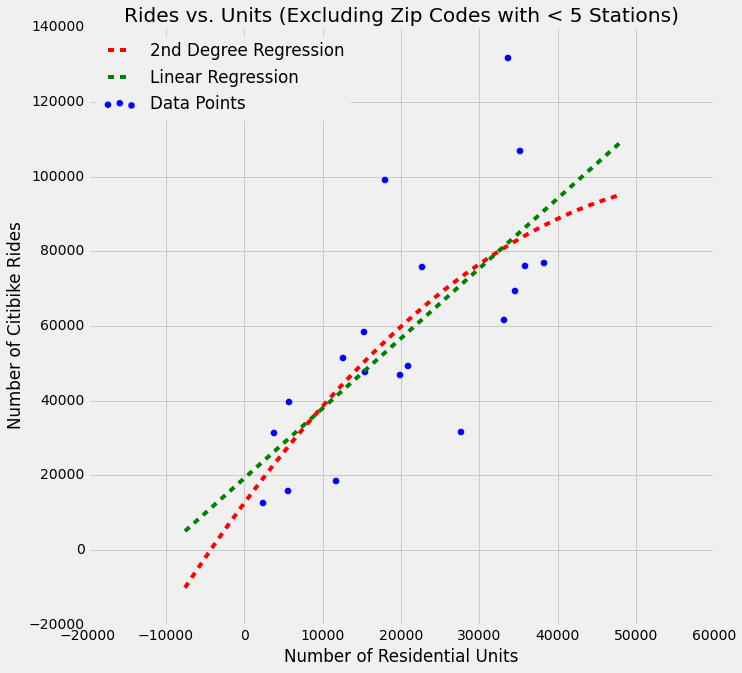

In [16]:
doRegressionAndPlot(df_filtered, 'Rides vs. Units (Excluding Zip Codes with < 5 Stations)')

In this case we get an LR Statistic of 0.264878125722 and a P-Value of 0.606788449998 therefore we cannot reject the linear model in favor of the polynomial model.

### Question 5
Once we exclude the outliers with low stations, our linear model performs better than our 2nd degree polynomial in terms of having a lower adjusted R-squared, indicating that the 2nd degree relationship is unecessary.

It seems fairly clear that there is a positive relationship between the number of residential units in an area and the number of citibike rides.  Which also seems intuitively true.  Although we don't have a very precise magnitude of the effect.  Excluding outliers, our 95% confidence interval for the coefficent of units has a range all the way from 0.919 to 2.825.

### Question 6

Our regression which included number of stations would indicate that number of residential units is actual a fairly *bad* predictor of number of rides originating from a destination.  In that case our 95% confidence interval from the coefficent for units is smaller in magnitude and even includes zero (-0.658 to 0.826).  This is likely because many rides will also originate at someone's workplace, in an area with much fewer residential units, or by tourists in similar locations.  A much better predictor would be density of people, including people living, working or visiting the area.  